# Recursive least squares

Let $X$ be a design matrix where the number of rows $m$ exceeds the number of columns $n$, and let $y$ the column vector of labels. The weight matrix $w$ that minimizes $\|Xw-y\|_2$ (under mild assumptions on $X$) is given by $w = (X^T X)^{-1}X^Ty$. In other words, the entries of $w$ give the coefficients of the linear equation that minimizes the ordinary least squares objective function.  

Suppose we want to update our model with new information.  Concretely, suppose we wish to update our regression model with the new observation $\tilde{x}$ (a column vector) and new label $t$ (a real number). $X$ will be augmented with a new row $\tilde{x}^T$ to form $\tilde{X}$, and $y$ will be augmented with the label $t$ to form $\tilde{y}$. How do we find the new weight vector $\tilde{w}$ that minimizes $\|\tilde{X}\tilde{w}-\tilde{y}\|_2$?

## Updating the weight vector
The most straightforward answer to the question above is to store $\tilde{X}$, then compute $\tilde{w} = (\tilde{X}^T \tilde{X})^{-1}\tilde{X}^T\tilde{y}$.  This is slow and inefficient:  the usual matrix multiplication algorithm requires $O(n m^2)$ time, and inverting the $n\times n$ matrix $\tilde{X}^T \tilde{X}$ requires $O(n^3)$ time (using Gaussian elimination). Of course, this computation requires us to store the matrix $\tilde{X}$, requiring $O(mn)$ space. This could become very costly if the number of observations $m$ is large. 

## Sherman-Morrison lemma
The key to a faster method will be efficiently moving from $(X^T X)^{-1}$ to $(\tilde{X}^T \tilde{X})^{-1}$. Define the usual inner product on vectors $x,y\in \mathbb{R}^n$ by $\langle x,y\rangle := x^T y$. If we already know $(X^T X)^{-1}$, we can compute 
$(\tilde{X}^T \tilde{X})^{-1}$ as follows using the [Sherman-Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula):
\begin{align*} (\tilde{X}^T \tilde{X})^{-1} &= (X^T X + \tilde{x}\tilde{x}^T)^{-1} \\
&= (X^T X)^{-1} - \alpha (X^T X)^{-1}\tilde{x}\tilde{x}^T (X^T X)^{-1}
\end{align*} 
where $\alpha = (1+\langle \tilde{x}, (X^T X)^{-1} \tilde{x}\rangle)^{-1}$. (Some discussions of RLS cite the [matrix inversion lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) in computing $(\tilde{X}^T \tilde{X})^{-1}$.  In fact, because $\tilde{x}\tilde{x}^T$ is rank one, the matrix inversion lemma is overkill.)

For ease of notation, define $A:=(X^T X)^{-1}$. Define a column vector $z$ by $z=A\tilde{x}$.  When we combine the equation for $\tilde{w}$ with our formula for $(\tilde{X}^T \tilde{X})^{-1}$, we have  $$ \tilde{w} = w -\alpha \langle x, w+tz\rangle z+tz.$$

## The algorithm

In summary, suppose we desire to update a design matrix $X$ and label column vector $y$ with a new observation $\tilde{x}$ (a column vector) and label $t$, respectively. We have computed $(X^T X)^{-1}$ and we have found $w$ that minimizes $\|Xw-y\|_2$.  To find the new weight vector $\tilde{w}$, we do the following:
* $A = (X^T X)^{-1}$ (given),
* $z = A\tilde{x}$
* $\alpha = (1+\langle \tilde{x}, z\rangle)^{-1}$
* $w \leftarrow  w -\alpha \langle x, w+tz\rangle z+tz$
* $A \leftarrow A - \alpha zz^T$

This is the _recursive least squares_ algorithm.  There are many variations on this algorithm that accomplish the same task in different ways.  For example, one version of the algorithm uses the QR decomposition and Givens rotations, instead of the matrix inversion lemma, to update the weight vector.  Another variation explores reducing the importance of old observations; we'll explore that next.

## Forgetting factor
We will now alter the requirements of updating the model by placing more importance on  recent observations. Let $0<\lambda < 1$ be the "forgetting factor."  Every time an observation is to be added to the design matrix, we first multiply the design matrix by $\sqrt{\lambda}$, then append the new observation. 

Given that we have done this and computed $(X^T X)^{-1}$, the calculation of $(\tilde{X}^T \tilde{X})^{-1}$ is similar to before:
\begin{align*}
(\tilde{X}^T \tilde{X})^{-1} &= (\lambda X^T X + \tilde{x}\tilde{x}^T)^{-1} \\
&= \lambda^{-1}(X^T X)^{-1} - \alpha \lambda^{-2}(X^T X)^{-1}\tilde{x}\tilde{x}^T (X^T X)^{-1}
\end{align*}
where $\alpha = (1+\langle \tilde{x}, \lambda^{-1}(X^T X)^{-1} \tilde{x}\rangle)^{-1}$. 

The algorithm using a forgetting factor is very similar to before.

* $A = \lambda^{-1}(X^T X)^{-1}$ (given),
* $z = A\tilde{x}$
* $\alpha = (1+\langle \tilde{x}, z\rangle)^{-1}$
* $w \leftarrow  w -\alpha \langle x, w+tz\rangle z+tz$
* $A \leftarrow A - \alpha zz^T$


## Speed and stability

Recall that the naive algorithm for computing $\tilde{w}$ is $O(n^3+m^2 n)$ time and $O(mn)$ space.  Recursive least squares is considerably better.  The first line of this algorithm requires $O(n^2)$ time (from $A\tilde{x}$). The second and third lines are also $O(n^2)$. The last line is actually $O(n)$. All told, this algorithm requires $O(n^2)$ time and $O(n^2)$ space. 

The major disadvantage of recursive least squares is the possibility that, as many observations are added, the weight vector $w$ begins to deviate from the "true" weight from round-off error accumulation.  This is beyond the scope of this summary.  Consult [this](http://www.telecom.tuc.gr/Greek/Liavas/publications/On%20the%20Numerical%20Stability%20and%20Accuracy%20of%20the%20Conventional%20Recursive%20Least%20Squares%20Algorithm.pdf) interesting paper for information about necessary conditions will guarantee stability.  

## Python implementation

In [1]:
class RLS:
    def __init__(self, num_vars, lam, delta):
        '''
        num_vars: number of variables including constant
        lam: forgetting factor, usually very close to 1.
        '''
        self.num_vars = num_vars
        
        # delta controls the initial state.
        self.A = delta*np.matrix(np.identity(self.num_vars))
        self.w = np.matrix(np.zeros(self.num_vars))
        self.w = self.w.reshape(self.w.shape[1],1)
        
        # Variables needed for add_obs
        self.lam_inv = lam**(-1)
        self.sqrt_lam_inv = math.sqrt(self.lam_inv)
        
        # A priori error
        self.a_priori_error = 0
        
        # Count of number of observations added
        self.num_obs = 0

    def add_obs(self, x, t):
        '''
        Add the observation x with label t.
        x is a column vector as a numpy matrix
        t is a real scalar
        '''            
        z = self.lam_inv*self.A*x
        alpha = float((1 + x.T*z)**(-1))
        self.a_priori_error = float(t - self.w.T*x)
        self.w = self.w + (t-alpha*float(x.T*(self.w+t*z)))*z
        self.A -= alpha*z*z.T
        self.num_obs += 1
        
    def fit(self, X, y):
        '''
        Fit a model to X,y.
        X and y are numpy arrays.
        Individual observations in X should have a prepended 1 for constant coefficient.
        '''
        for i in range(len(X)):
            x = np.transpose(np.matrix(X[i]))
            self.add_obs(x,y[i])


    def get_error(self):
        '''
        Finds the a priori (instantaneous) error. 
        Does not calculate the cumulative effect
        of round-off errors.
        '''
        return self.a_priori_error
    
    def predict(self, x):
        '''
        Predict the value of observation x. x should be a numpy matrix (col vector)
        '''
        return float(self.w.T*x)

## Testing
We test the implementation on a noisy quadratic signal. We will attempt to approximate with a 2nd degree polynomial. In this test, we are looking to see if the weight vector from RLS is close to the weight vector of the quadratic signal.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

[[-5.05458678]
 [-3.80046535]
 [ 0.20000064]]


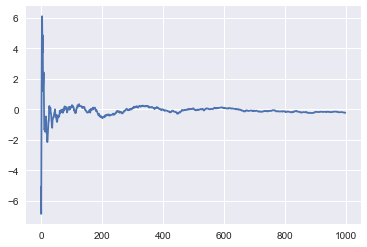

In [3]:
test_size = 1000
# Test function
f = lambda x: 0.2*x**2-3.8*x-5.1
# Gaussian noise to be added to the quadratic signal
noise = np.random.randn(test_size)
# You can play around with other noise (like sinusoidal)
#noise = [np.sin(2*np.pi*i/13) for i in range(test_size)]
y = np.array([f(i) for i in range(test_size)])
noisy_y = y + noise
lam = 0.98
LS = RLS(3,lam,1)
# Not using the RLS.fit function because I want to remember all the predicted values
pred_x = []
pred_y = []
for i in range(test_size):
    x = np.matrix(np.zeros((1,3)))
    x[0,0] = 1
    x[0,1] = i
    x[0,2] = i**2
    pred_x.append(i)
    pred_y.append(float(x*LS.w))
    LS.add_obs(x.T,noisy_y[i])
print(LS.w)
# plot the predicted values against the non-noisy output
ax = plt.plot(pred_x, y-pred_y)
plt.show()

This looks good.  The RLS coefficients are near the coefficients that determine y. As the number of observations increases, the difference between predicted values and the non-noisy values hovers near 0.

## Learning functions
We can use RLS to learn functions. Below we approximate $\frac{3x}{1+10x^2}$ using a 3rd degree polynomial on the interval $[0,1]$ using 1000 evenly spaced points.

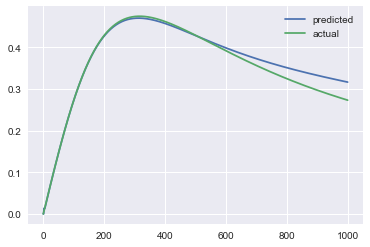

In [4]:
test_size = 1000
# Test function
f = lambda x: 3*x/(1+10*x**2)
# Gaussian noise to be added to the quadratic signal
noise = np.random.randn(test_size)
# You can play around with other noise (like sinusoidal)
#noise = [np.sin(2*np.pi*i/13) for i in range(1000)]
y = np.array([f(i/test_size) for i in range(test_size)])
#noisy_y = y + noise
lam = 1
num_vars = 4
LS = RLS(num_vars,lam,1)
# We won't use RLS.fit because I want to save the predictions.
pred_x = []
pred_y = []
for i in range(test_size):
    x = np.matrix(np.zeros((1,num_vars)))
    for j in range(num_vars):
        x[0,j] = i**j 
    pred_x.append(i)
    pred_y.append(float(x*LS.w))
    LS.add_obs(x.T,y[i])
ax = plt.plot(pred_x, pred_y,label='predicted')
_ = plt.plot(pred_x,y,label='actual')
plt.legend()
plt.show()

## Recursive least squares in time series analysis
RLS has a long history in time series analysis.  Let's use RLS to predict the closing value of the S&P 500 (actually we'll use the ticker symbol SPY) for the next day.   Here's how the model will work: for each day, we'll predict the closing cost and store the value. Then the model is updated with the actual closing price.  This is meant to simulate the following scenario: you predict today's closing price and make a decision based on the prediction.  At close, you input the closing price into the model and it updates.

This model is not meant as a serious tool, and its predictive value is certainly not intended to be helpful beyond 1 day, if it all.  But it is interesting that the hyperparameters of the model (degree, lambda, and delta) can be tuned to get results that at least look good.  


In [5]:
# use pandas-datareader to import the stock info
import pandas_datareader as web
import datetime
start = datetime.date(2016,7,11)
end = datetime.date(2018, 7, 11)
f = web.DataReader('SPY', 'iex', start, end)

5y


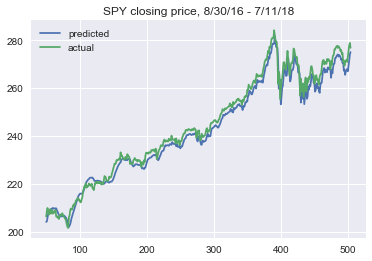

In [6]:
test_size = len(f)
y = f['close'].values
lam = 0.98
delta = 10
num_vars = 5
LS = RLS(num_vars, lam, delta)
# We won't use RLS.fit because I want to save the predictions.
pred_x = []
pred_y = []
pred_error = []
for i in range(test_size):
    x = np.matrix(np.zeros((1,num_vars)))
    for j in range(num_vars):
        x[0,j] = i**j 
    pred_x.append(i)
    pred_y.append(float(x*LS.w))
    pred_error.append(LS.get_error())
    LS.add_obs(x.T,y[i])
ax = plt.plot(pred_x[50:], pred_y[50:],label='predicted')
_ = plt.plot(pred_x[50:],y[50:],label='actual')
_ = plt.title("SPY closing price, 8/30/16 - 7/11/18")
plt.legend()
plt.show()

In [7]:
# Determine how often the model predicted the correct stock movement
correct_sign = 0
for i in range(1,test_size):
    if np.sign(y[i]-y[i-1]) == np.sign(pred_x[i]-pred_x[i-1]):
        correct_sign += 1
print(float(correct_sign)/test_size)

0.5584158415841585


In [8]:
# Predict the SPY closing price for 7/12/18
x = np.matrix(np.zeros((1,num_vars)))
for j in range(num_vars):
    x[0,j] = (test_size)**j 
LS.predict(x.T)

273.01971658817456

You could automate this process pretty easily.